## План работы:
1. Подготовка блокнота: загрузка необходимых для работы библиотек;
2. Загрузка датасета Goodreads-books из .csv файла;
3. Предварительный анализ данных: поиск пропусков, статистический анализ;
4. Визуализация основных показателей: топ книг по рейтингу, топ авторов по рейтингу, самый популярный язык и тд.;
Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения.
5. Подготовка к созданию модели машинного обучения: очистка данных, разделение датасета на обучающий и тестовый;
6. Создание модели машинного обучения для предсказания среднего рейтинга;
7. Создание рекомендательной системы книг на основе Метода ближайших соседей (KNN).

#### 1. Загрузка библиотек

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn import neighbors
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### 2. Загрузка датасета Goodreads-books

In [2]:
df = pd.read_csv('.\Goodreads-books.csv', on_bad_lines='skip')
df.dropna(axis=0, how='any', inplace=True)
# on_bad_lines с ключем skip используется для пропуска ошибки при загрузке пустых строк из исходного датасета.

#### 3. Предварительный анализ данных

In [3]:
# Просмотр данных в целом - из чего состоит датасет:
df.head(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [4]:
# Тип данных в датасете: 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


In [5]:
# Переименование столбца для дальнейшего удобства в работе
df = df.rename({'  num_pages': 'num_pages'}, axis=1)

In [6]:
# Наименование колонок в датасете:
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

Подробнее о колонках:
###### 'bookID' - Номер книги по порядку в данном датасете;
###### 'title' - Название книги;
###### 'authors' - Имя/Фамилия автора книги;
###### 'average_rating' - Средний рейтинг;
###### 'isbn' - Международный стандартный книжный номер (10 цифр);
###### 'isbn13' - Международный стандартный книжный номер (13 цифр);
###### 'language_code' - Язык издания;
###### 'num_pages' - Количество страниц;
###### 'ratings_count' - Количество учтенных рейтингов;
###### 'text_reviews_count' - Количество текстовых отзывов;
###### 'publication_date' - Дата выхода книги в печать;
###### 'publisher' - Издательство, выпустившее книгу.

In [7]:
# Описательный анализ: подсчет строк, максимальные/минимальные/средние показатели и т.п.
df.describe()

,bookID,average_rating,isbn13,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


In [8]:
# Наличие пустых строк:
df.isnull().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

In [9]:
# Пропущенные значения в строках в процентах
mis_val = 100 * df.isnull().sum() / len(df)
print(mis_val)

bookID                0.0
title                 0.0
authors               0.0
average_rating        0.0
isbn                  0.0
isbn13                0.0
language_code         0.0
num_pages             0.0
ratings_count         0.0
text_reviews_count    0.0
publication_date      0.0
publisher             0.0
dtype: float64


In [10]:
# Размер датасета:
df.shape

(11123, 12)

In [11]:
# Размер через счетчик:
total_count = df.shape[0]
print('Всего строк: {}'.format(total_count))
total_count = df.shape[1]
print('Всего столбцов: {}'.format(total_count))

Всего строк: 11123
Всего столбцов: 12


### 4. Визуализация основных показателей

In [12]:
# Узнаем, с каким количеством авторов и языков будем иметь дело:
num_author = len(pd.unique(df['authors']))
num_lang = len(pd.unique(df['language_code']))
print('Количество авторов: ', num_author, ', ', 'Языки произведений: ', num_lang, '.', sep='')

Количество авторов: 6639, Языки произведений: 27.


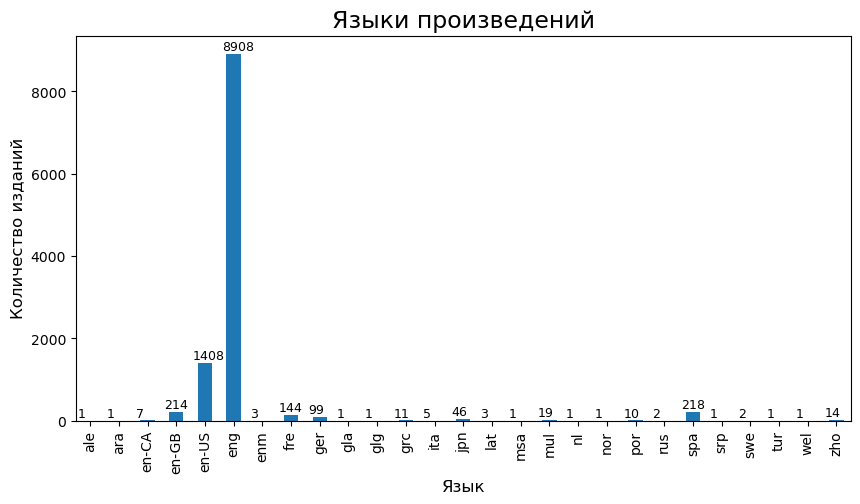

In [13]:
# Языки произведений (все 27):
plt.figure(figsize=(10,5))
ax = df.groupby('language_code')['title'].count().plot.bar()
plt.title('Языки произведений', fontsize=17)
plt.xlabel('Язык', fontsize=12)
plt.ylabel('Количество изданий', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()-0.168, p.get_height()+80), fontsize=9)
plt.show()

In [14]:
# Две книги на русском
rus_books = df[df['language_code'] == 'rus']
rus_books.sort_values(by='title', ascending=False).head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
4934,17837,Мастер и Маргарита,Mikhail Bulgakov/Михаил Булгаков,4.30,5040019521,9785040019526,rus,640,10,1,9/28/2004,Эксмо
5288,19104,The Overcoat and Other Short Stories,Nikolai Gogol,4.21,0486270572,9780486270579,rus,103,8944,196,2/21/1992,Dover Publications


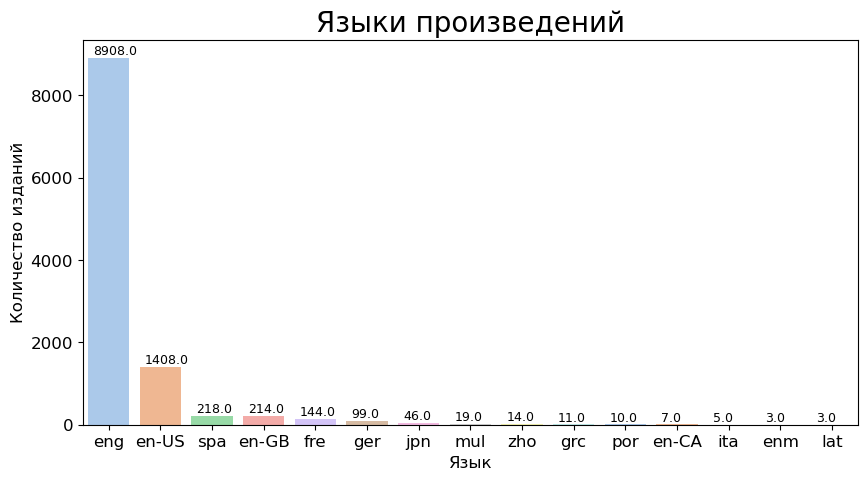

In [15]:
# Языки произведений (с цифрами, не округлено)
plt.figure(figsize=(10,5))
ax = sns.countplot(x = 'language_code', data=df, order=df['language_code'].value_counts().round().index[0:15], palette='pastel')
plt.title('Языки произведений', fontsize=20)
plt.xlabel('Язык', fontsize=12)
plt.ylabel('Количество изданий', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_height()+80), fontsize=9)
plt.show()

In [16]:
# Авторы с самым большим количеством книг:
df['authors'].value_counts().head(10)

Stephen King        40
P.G. Wodehouse      40
Rumiko Takahashi    39
Orson Scott Card    35
Agatha Christie     33
Piers Anthony       30
Sandra Brown        29
Mercedes Lackey     29
Dick Francis        28
Terry Pratchett     23
Name: authors, dtype: int64

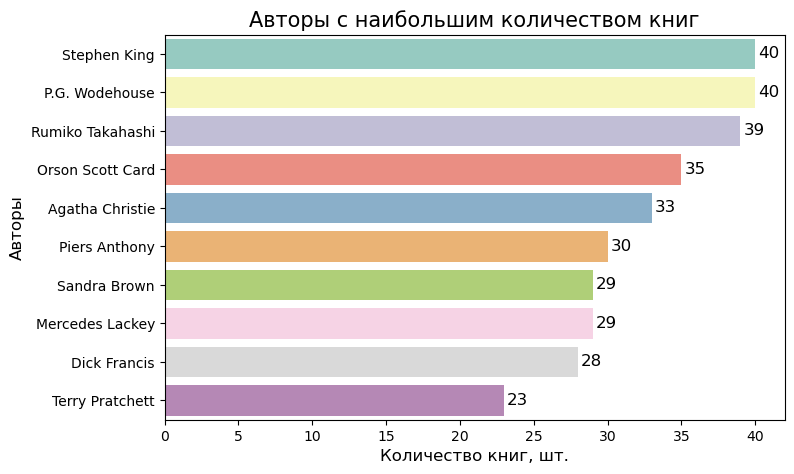

In [17]:
# Авторы с самым большим количеством книг (визуализация):
plt.figure(figsize=(8,5))
ax = sns.countplot(y="authors", data = df, order = df['authors'].value_counts().index[0:10], palette = "Set3")
plt.title("Авторы с наибольшим количеством книг", fontsize=15)
plt.xlabel('Количество книг, шт.', fontsize=12)
plt.ylabel('Авторы', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
totals = []
for i in ax.patches:
    totals.append(i.get_width())
totals = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.2, i.get_y()+0.5,str(round(i.get_width())), fontsize=12)
plt.show()

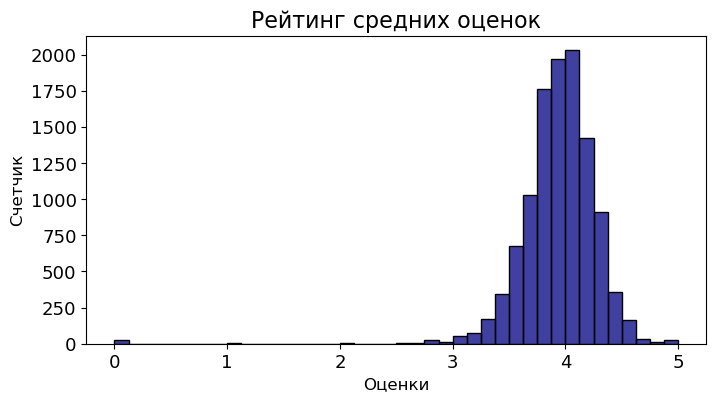

In [18]:
# Средние оценки в датасете
plt.figure(figsize=(8,4))
sns.histplot(df['average_rating'], bins=40, color='navy')
plt.title('Рейтинг средних оценок', fontsize=16)
plt.xlabel("Оценки", fontsize=12)
plt.ylabel("Счетчик", fontsize=12)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

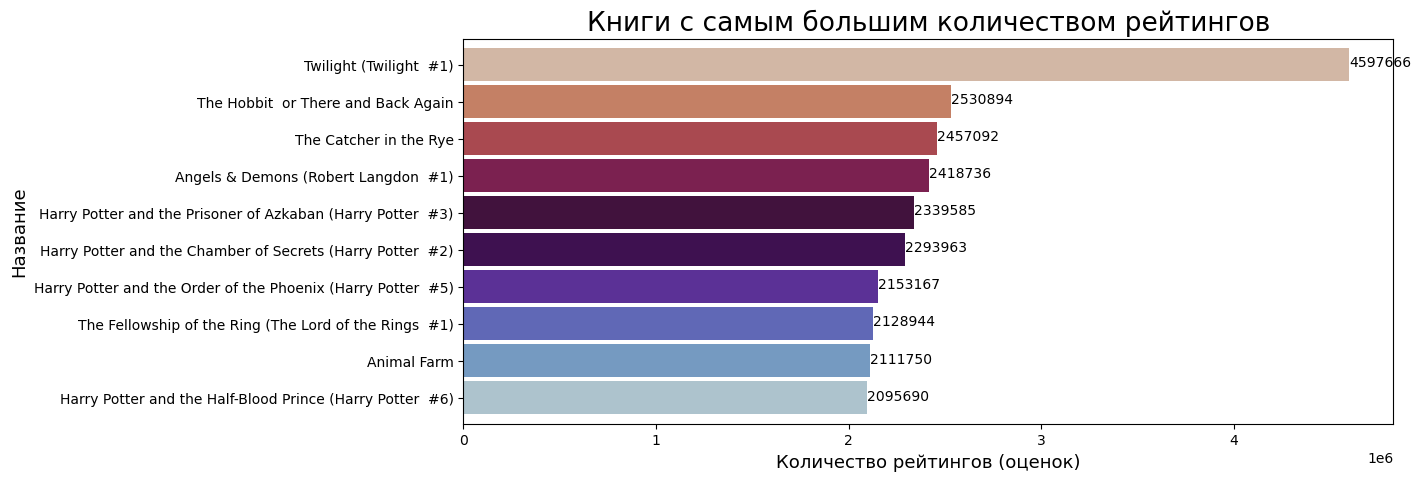

In [19]:
# Книги с самым большим количеством рейтингов
plt.subplots(figsize=(12,5))
most_rated = df.sort_values('ratings_count',ascending=False).head(10).set_index('title')
ax = most_rated['ratings_count'].sort_values().plot.barh(width=0.9, color=sns.color_palette('twilight', 10))
ax.set_title('Книги с самым большим количеством рейтингов', fontsize=19,color='black')
ax.set_xlabel('Количество рейтингов (оценок)', fontsize=13)
ax.set_ylabel('Название', fontsize=13)
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+5, i.get_y()+0.4,str(round(i.get_width())), fontsize=10,color='black')
plt.show()

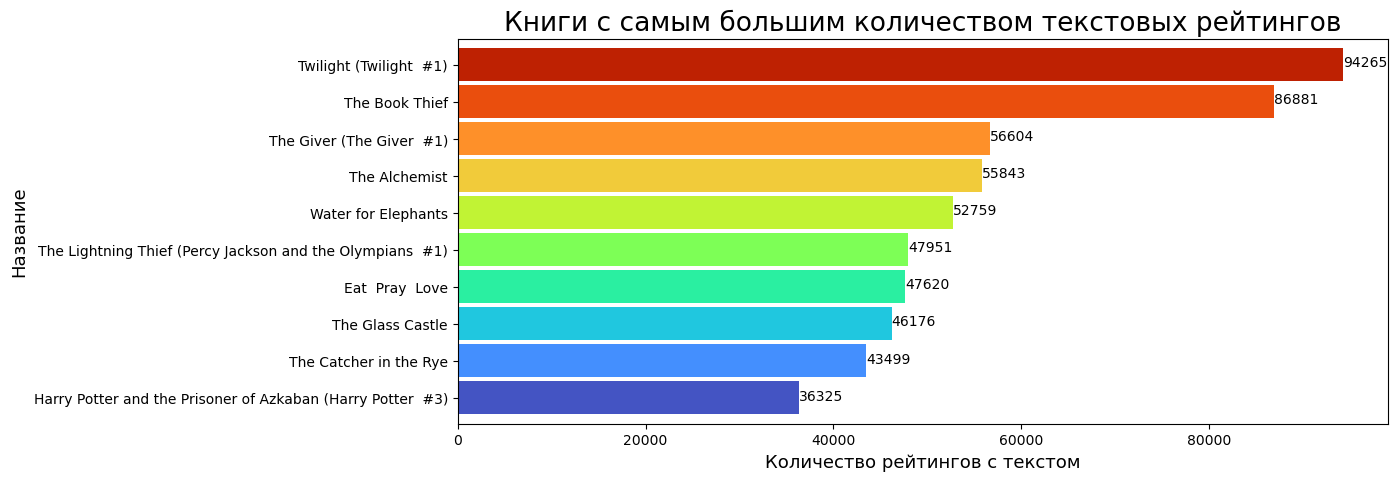

In [20]:
# Книги с самым большим количеством текстовых рейтингов
plt.subplots(figsize=(12,5))
most_rated = df.sort_values('text_reviews_count',ascending=False).head(10).set_index('title')
ax = most_rated['text_reviews_count'].sort_values().plot.barh(width=0.9, color=sns.color_palette('turbo', 10))
ax.set_title('Книги с самым большим количеством текстовых рейтингов', fontsize=19,color='black')
ax.set_xlabel('Количество рейтингов с текстом', fontsize=13)
ax.set_ylabel('Название', fontsize=13)
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+5, i.get_y()+0.4,str(round(i.get_width())), fontsize=10,color='black')
plt.show()

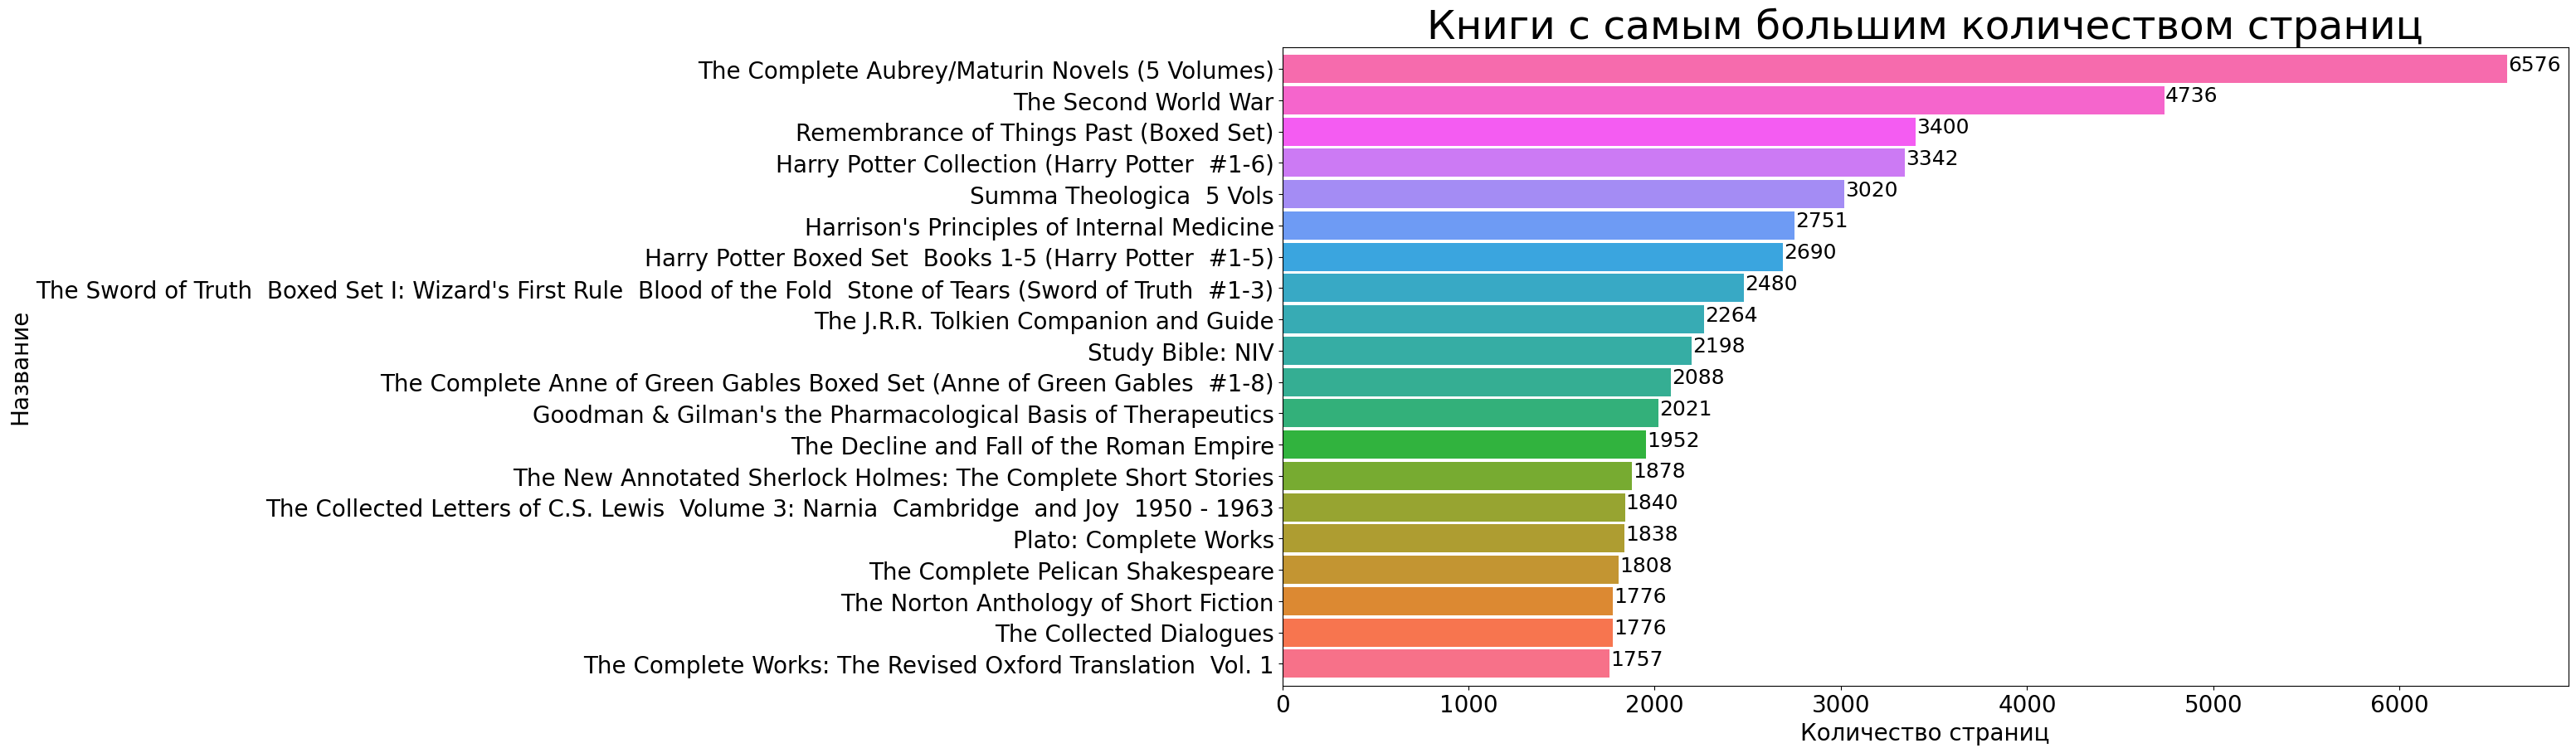

In [21]:
# Книги с самым большим количеством страниц
plt.subplots(figsize=(20,10))
most_rated = df.sort_values('num_pages',ascending=False).head(20).set_index('title')
ax = most_rated['num_pages'].sort_values().plot.barh(width=0.9, color=sns.color_palette('husl', 20))
ax.set_title('Книги с самым большим количеством страниц', fontsize=35,color='black')
ax.set_xlabel('Количество страниц', fontsize=20)
ax.set_ylabel('Название', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+5, i.get_y()+0.4,str(round(i.get_width())), fontsize=18, color='black')
plt.show()

### 5. Подготовка к созданию модели машинного обучения

In [22]:
# Создаем копию датасета
df1=df.copy()
df1.head(3)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic


In [23]:
# Книги без рейтинга! (Нет ни одного учтенного рейтинга, хотя средний - проставлен)
df_filt1 = df1[df1['ratings_count'] == 0]
print('Всего строк, столбцов', df1.shape)
print('Из них с пустым количеством', df_filt1.shape)

Всего строк, столбцов (11123, 12)
Из них с пустым количеством (80, 12)


In [24]:
df1 = df1.drop(df1.index[df1['ratings_count'] == 0])
print('Всего строк, столбцов', df1.shape)

Всего строк, столбцов (11043, 12)


In [25]:
# Наличие книг с пустым количеством страниц
df_filt2 = df1[df1['num_pages'] == 0]
print('Всего строк, столбцов', df1.shape)
print('Из них с пустым количеством', df_filt2.shape)

Всего строк, столбцов (11043, 12)
Из них с пустым количеством (75, 12)


In [26]:
# Удаление книг с нулевым количеством страниц, просмотр размера датасета после удаления
df1 = df1.drop(df1.index[df1['num_pages'] == 0])
print('Всего строк, столбцов', df1.shape)

Всего строк, столбцов (10968, 12)


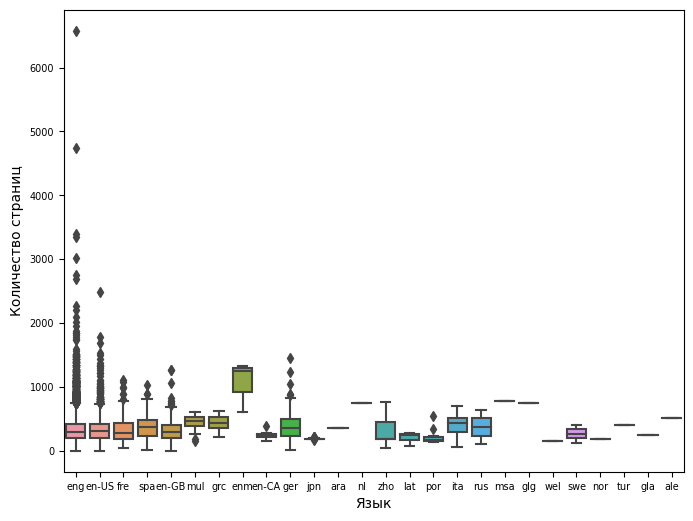

In [27]:
# Выбросы по количеству страниц относительно разных языков
plt.figure(figsize=(8,6))
sns.boxplot(data=df1, x='language_code', y='num_pages')
plt.xlabel('Язык')
plt.ylabel('Количество страниц')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

Количество страниц больше 1500:  31


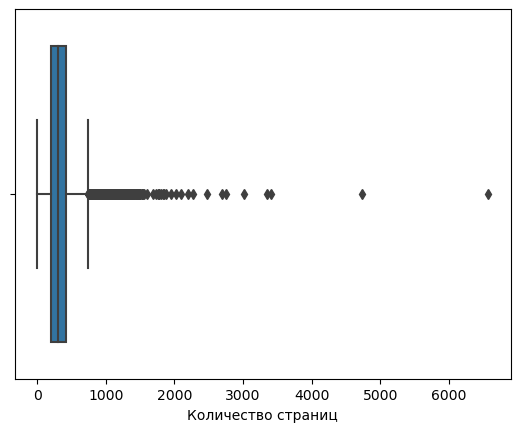

In [28]:
# Ящик с усами для просмотра выбросов по количеству страниц
sns.boxplot(data=df1, x='num_pages')
plt.xlabel('Количество страниц', fontsize=10)
print('Количество страниц больше 1500: ', len(df1[df1['num_pages'] >= 1500]))

In [29]:
# Для повышения точности работы модели удалим книги с очень большим кол-вом страниц
df1 = df1.drop(df1.index[df1['num_pages'] >= 1500])
print('Всего строк, столбцов', df1.shape)

Всего строк, столбцов (10937, 12)


Рейтинг ниже 2.0:  8


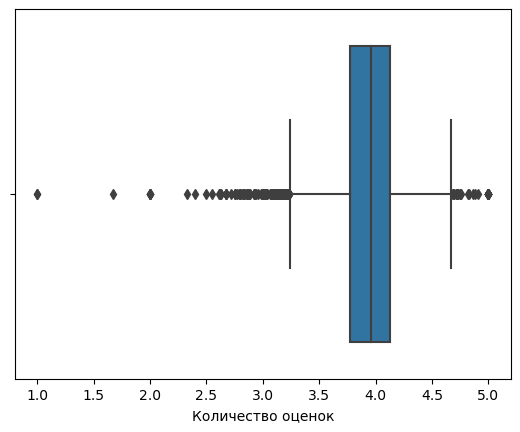

In [30]:
# Ящик с усами для просмотра выбросов по среднему рейтингу
sns.boxplot(data=df1, x='average_rating')
plt.xlabel('Количество оценок', fontsize=10)
print('Рейтинг ниже 2.0: ', len(df1[df1['average_rating'] <= 2.0]))

In [31]:
# Так же удалим книги с очень большим кол-вом страниц
df1 = df1.drop(df1.index[df1['average_rating'] <= 2.0])
print('Всего строк, столбцов', df1.shape)

Всего строк, столбцов (10929, 12)


In [32]:
# Удалим лишние столбцы с числовыми показателями
df1.drop(['bookID','isbn','isbn13'],axis=1,inplace=True)
df1.head(3)

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333,244,11/1/2003,Scholastic


In [33]:
# Слишком много упоминаний английского языка в датасете, объединим
english = {'language_code':{'en-US': 'eng', 'en-GB': 'eng', 'en-CA': 'eng'}}
df1.replace(english, inplace=True)

In [34]:
# Кодируем столбец с языком произведения номером индекса
lang_code = df1.groupby('language_code').size()
lang_code = lang_code/len(df1)
df1['lang_code'] = df1['language_code'].map(lang_code).round(3)

df1['lang_code']

0        0.948
1        0.948
2        0.948
3        0.948
5        0.948
         ...  
11118    0.948
11119    0.948
11120    0.948
11121    0.948
11122    0.019
Name: lang_code, Length: 10929, dtype: float64

In [35]:
print(str(round(len(df1[df1.lang_code == 0.948])/len(df1)*100,2)) + "% книг на английском языке")

94.82% книг на английском языке


In [36]:
# Кодируем столбец с издателем номером индекса
lang_code = df1.groupby('publisher').size()
lang_code = lang_code/len(df1)
df1['publisher_code'] = df1['publisher'].map(lang_code).round(3)

df1['publisher_code']

0        0.001
1        0.001
2        0.003
3        0.001
5        0.000
         ...  
11118    0.002
11119    0.024
11120    0.024
11121    0.002
11122    0.000
Name: publisher_code, Length: 10929, dtype: float64

In [37]:
# Кодируем столбец с автором номером индекса
lang_code = df1.groupby('authors').size()
lang_code = lang_code/len(df1)
df1['authors_code'] = df1['authors'].map(lang_code).round(3)

df1['authors_code']

0        0.000
1        0.000
2        0.001
3        0.000
5        0.000
         ...  
11118    0.000
11119    0.000
11120    0.000
11121    0.000
11122    0.000
Name: authors_code, Length: 10929, dtype: float64

In [38]:
df1.head(3)

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,lang_code,publisher_code,authors_code
0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,0.948,0.001,0.000
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,0.948,0.001,0.000
2,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333,244,11/1/2003,Scholastic,0.948,0.003,0.001


In [39]:
df.isnull().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

In [40]:
# Топ 5 книг исходя из количества учтенных тектовых рейтингов
top_5_with_text = df1[df1['text_reviews_count'] >= 5000]
top_5_with_text.sort_values(by='average_rating', ascending=False).head(5)

,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,lang_code,publisher_code,authors_code
0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,0.948,0.001,0.0
3,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,0.948,0.001,0.0
4244,The Complete Maus,Art Spiegelman,4.55,eng,296,111475,5966,10/2/2003,Penguin Books,0.948,0.024,0.0
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,0.948,0.001,0.0
10528,Lover Awakened (Black Dagger Brotherhood #3),J.R. Ward,4.45,eng,448,144906,5728,9/5/2006,Signet,0.948,0.006,0.0


In [41]:
# Удаление колонок с уникальными значениями, которые не пригодятся для обучения модели:
df1.drop(['title','authors','language_code','publication_date','publisher'],axis=1,inplace=True)
df1.head(10)

,average_rating,num_pages,ratings_count,text_reviews_count,lang_code,publisher_code,authors_code
0,4.57,652,2095690,27591,0.948,0.001,0.000
1,4.49,870,2153167,29221,0.948,0.001,0.000
2,4.42,352,6333,244,0.948,0.003,0.001
3,4.56,435,2339585,36325,0.948,0.001,0.000
5,3.74,152,19,1,0.948,0.000,0.000
7,4.38,815,3628,254,0.948,0.001,0.001
8,4.38,815,249558,4080,0.948,0.003,0.001
9,4.22,215,4930,460,0.948,0.001,0.001
10,4.22,6,1266,253,0.948,0.001,0.000
11,4.38,815,2877,195,0.948,0.000,0.001


In [42]:
# Просмотр корреляций в датасете
df1.corr()

,average_rating,num_pages,ratings_count,text_reviews_count,lang_code,publisher_code,authors_code
average_rating,1.000000,0.155330,0.041126,0.033967,-0.041142,-0.036576,-0.008972
num_pages,0.155330,1.000000,0.039367,0.043782,-0.026485,0.083783,0.070921
ratings_count,0.041126,0.039367,1.000000,0.865936,0.031887,0.026651,0.041468
text_reviews_count,0.033967,0.043782,0.865936,1.000000,0.044529,0.042301,0.042308
lang_code,-0.041142,-0.026485,0.031887,0.044529,1.000000,0.126346,-0.023022
publisher_code,-0.036576,0.083783,0.026651,0.042301,0.126346,1.000000,0.033520
authors_code,-0.008972,0.070921,0.041468,0.042308,-0.023022,0.033520,1.000000


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, 'average_rating'),
  Text(0, 1.5, 'num_pages'),
  Text(0, 2.5, 'ratings_count'),
  Text(0, 3.5, 'text_reviews_count'),
  Text(0, 4.5, 'lang_code'),
  Text(0, 5.5, 'publisher_code'),
  Text(0, 6.5, 'authors_code')])

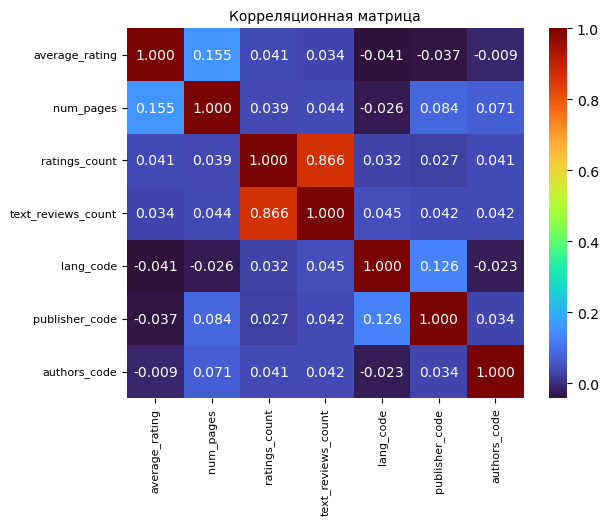

In [43]:
# Более наглядный вид - тепловая карта:
sns.heatmap(df1.corr(), annot=True, fmt='.3f', cmap='turbo')
plt.title('Корреляционная матрица', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

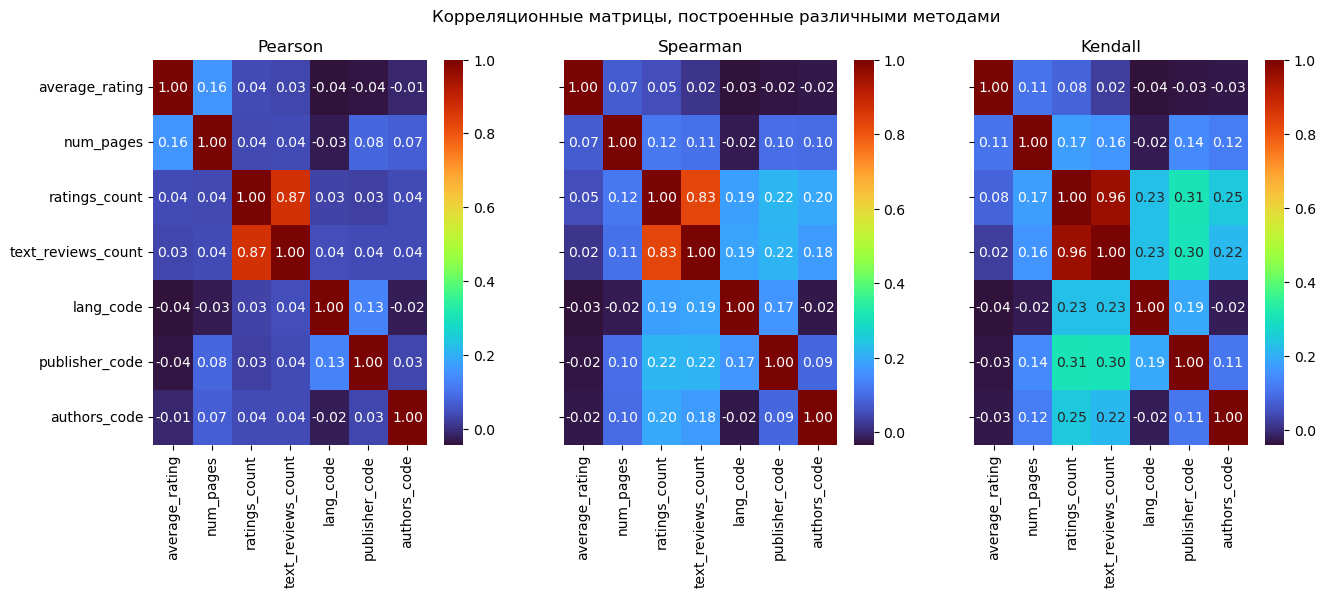

In [44]:
# Корреляционные матрицы, построенные различными методами
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,5))
sns.heatmap(df1.corr(method='pearson'), ax=ax[0], annot=True, fmt='.2f', cmap='turbo')
sns.heatmap(df1.corr(method='spearman'), ax=ax[2], annot=True, fmt='.2f', cmap='turbo')
sns.heatmap(df1.corr(method='kendall'), ax=ax[1], annot=True, fmt='.2f', cmap='turbo')
fig.suptitle('Корреляционные матрицы, построенные различными методами')
ax[0].title.set_text('Pearson')
ax[1].title.set_text('Spearman')
ax[2].title.set_text('Kendall')

In [45]:
# Корреляция среднего рейтинга к остальным показателям:
df1.corrwith(df1.average_rating, numeric_only=True).sort_values()

lang_code            -0.041142
publisher_code       -0.036576
authors_code         -0.008972
text_reviews_count    0.033967
ratings_count         0.041126
num_pages             0.155330
average_rating        1.000000
dtype: float64

##### На основе корреляционной матрицы можно сделать следующие выводы:
Прослеживается взаимосвязь между рейтингами, содержищими текст и общим количеством учтенных рейтингов.
Можно сделать предположение, что при наличии текста в оценке книги её средний рейтинг становится выше. Есть смысл поискать, какие рейтинги с текстом наиболее высокие и у каких авторов.
Соответственно, если у одного автора много высокорейтинговых книг, можно предположить, что в будущем продажи его книг будут на очень высоком уровне.

<Figure size 600x700 with 0 Axes>

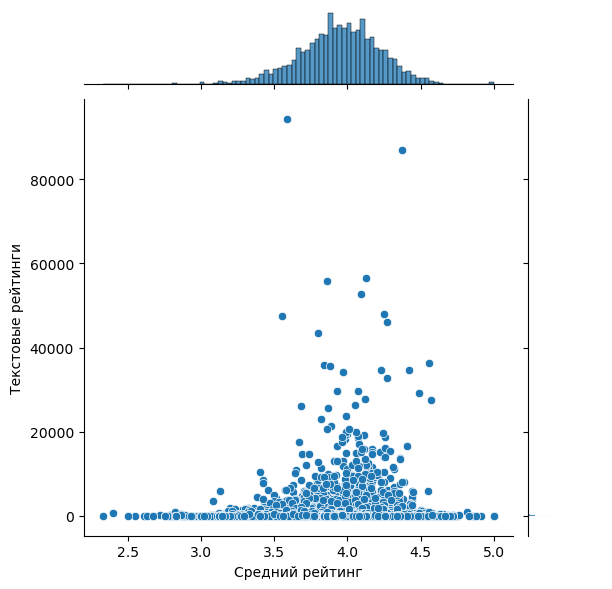

In [46]:
# Подробно о взаимосвязи среднего рейтинга и тектовых рейтингов:
plt.figure(figsize=(6,7))
ax = sns.jointplot(x='average_rating', y='text_reviews_count', data=df1[['text_reviews_count', 'average_rating']], kind='scatter')
ax.set_axis_labels('Средний рейтинг', 'Текстовые рейтинги')
plt.show()

<Figure size 1000x700 with 0 Axes>

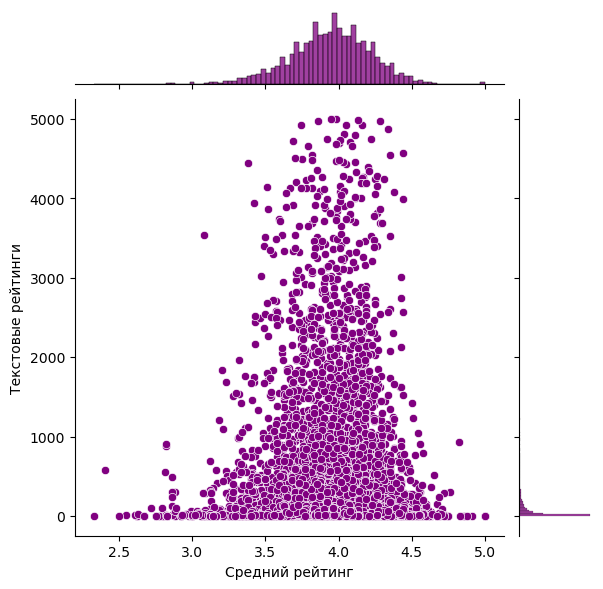

In [47]:
# Укрупненный масштаб (отзывы с текстовыми рейтингами меньше 5000)
closer = df1[~(df1['text_reviews_count'] > 5000)]
plt.figure(figsize=(10,7))
ax = sns.jointplot(x='average_rating', y='text_reviews_count',  data=closer, kind='scatter', color='purple')
ax.set_axis_labels('Средний рейтинг', 'Текстовые рейтинги')
plt.show()

Из графика явно следствует, что существует взаимосвязь между средним рейтингом книги и текстовым отзывом. Другими словами, на книги с хорошим рейтингом всегда много отзывов с текстом.

### 6. Создание модели машинного обучения для предсказания среднего рейтинга

In [48]:
# Делаем копию очищенного датасета
df1_clear = df1.copy()
df1_clear.shape

(10929, 7)

In [49]:
# Предварительный просмотр
df1_clear.head()

,average_rating,num_pages,ratings_count,text_reviews_count,lang_code,publisher_code,authors_code
0,4.57,652,2095690,27591,0.948,0.001,0.000
1,4.49,870,2153167,29221,0.948,0.001,0.000
2,4.42,352,6333,244,0.948,0.003,0.001
3,4.56,435,2339585,36325,0.948,0.001,0.000
5,3.74,152,19,1,0.948,0.000,0.000


In [50]:
# Перемещение целевых данных в отдельную переменную
y = df1_clear['average_rating']

In [51]:
# Перемещение данных по индексам (: - с нулевой по последнюю, 1: - с первой по последнюю)
X = df1_clear.iloc[:, 1:]

In [52]:
# Разделяем массивы для обучения модели, train_size - размер тренировочной части
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)
X_train.shape, X_test.shape

((7650, 6), (3279, 6))

#### Регрессионные модели

In [53]:
# Линейная регрессия
model  = LinearRegression()
parameters = {'fit_intercept': [True, False],'normalize': [True, False]}

grad_Linear = GridSearchCV(model, parameters, refit=True)
grad_Linear.fit(X_train, y_train)

print('Лучший результат: ', grad_Linear.best_score_*100, '\nЛучшие параметры: ', grad_Linear.best_params_)

Лучший результат:  3.062007672686584 
Лучшие параметры:  {'fit_intercept': True, 'normalize': False}


In [54]:
# Предсказание на модели линейной регрессии
pred_lr = grad_Linear.predict(X_test)

# Результаты
print('MAE: ' +str(np.sqrt(mean_absolute_error(y_test, pred_lr))))
print('R2: ', r2_score(y_test, pred_lr))

MAE: 0.4709750932696985
R2:  0.02139284140943143


In [55]:
# Сравнение актуальных оценок и предсказанных моделью
pred = pd.DataFrame({'Обучающие данные': y_test.tolist(), 
                     'Предсказание': pred_lr.tolist()}).head(5)
pred.head()

,Обучающие данные,Предсказание
0,4.30,3.893007
1,3.80,3.970500
2,3.49,3.906495
3,3.78,3.908899
4,4.04,3.933579


In [56]:
# AdaBoost регрессор
model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4))
parameters = {'learning_rate': [0.001, 0.01, 0.02, 0.1, 0.2, 1.0],'n_estimators': [10, 50, 100]}

grad_Ada = GridSearchCV(model, parameters, refit=True)
grad_Ada.fit(X_train, y_train)

print('Лучший результат: ', grad_Ada.best_score_*100, '\nЛучшие параметры: ', grad_Ada.best_params_)

Лучший результат:  6.041565938127091 
Лучшие параметры:  {'learning_rate': 0.001, 'n_estimators': 50}


In [57]:
# Предсказание на модели AdaBoost
pred_adaboost = grad_Ada.predict(X_test)

# Результаты
print('MAE: ' +str(np.sqrt(mean_absolute_error(y_test, pred_adaboost))))
print('R2: ', r2_score(y_test, pred_adaboost))

MAE: 0.4658131592121244
R2:  0.0655268579958378


In [58]:
# Сравнение актуальных оценок и предсказанных моделью
pred = pd.DataFrame({'Обучающие данные': y_test.tolist(), 
                     'Предсказание': pred_adaboost.tolist()}).head(5)
pred.head()

,Обучающие данные,Предсказание
0,4.30,3.909610
1,3.80,3.903073
2,3.49,3.899811
3,3.78,3.904501
4,4.04,3.955641


In [59]:
# Случайный лес
model = RandomForestRegressor()
parameters = {'n_estimators': [50, 100, 150],'max_depth': [3, 5, 7, 10, 12],
              'min_samples_split': [5, 10, 15],'min_samples_leaf': [5, 10, 15]}

grad_rf = GridSearchCV(model, parameters, refit=True, cv=10)
grad_rf.fit(X_train, y_train)

print('Лучший результат: ', grad_rf.best_score_*100, '\nЛучшие параметры: ', grad_rf.best_params_)

Лучший результат:  10.638705686236172 
Лучшие параметры:  {'max_depth': 12, 'min_samples_leaf': 15, 'min_samples_split': 5, 'n_estimators': 150}


In [60]:
# Предсказание на модели Случайного леса
pred_rf = grad_rf.predict(X_test)

# Результаты
print('MAE: ' +str(np.sqrt(mean_absolute_error(y_test, pred_rf))))
print('R2: ', r2_score(y_test, pred_rf))

MAE: 0.45995833143986675
R2:  0.11041256564055824


In [61]:
# Сравнение актуальных оценок и предсказанных моделью
pred = pd.DataFrame({'Обучающие данные': y_test.tolist(), 
                     'Предсказание': pred_rf.tolist()}).head(5)
pred.head()

,Обучающие данные,Предсказание
0,4.30,3.859217
1,3.80,3.965134
2,3.49,3.765746
3,3.78,3.928915
4,4.04,3.903693


Создадим таблицу и график с результатами

In [62]:
l = []
l.append(('Linear Regression', grad_Linear.best_score_*100))
l.append(('AdaBoost', grad_Ada.best_score_*100))
l.append(('Random Forest', grad_rf.best_score_*100))
scores = pd.DataFrame(l, index=['Linear \nRegression', 'AdaBoost', 'Random \nForest'], columns=['Модель', 'Обучение'])

In [63]:
l2 = []
l2.append(('Linear Regression', grad_Linear.score(X_test, y_test)*100))
l2.append(('AdaBoost', grad_Ada.score(X_test, y_test)*100))
l2.append(('Random Forest', grad_rf.score(X_test, y_test)*100))
test_scores = pd.DataFrame(l2, index=['Linear \nRegression', 'AdaBoost', 'Random \nForest'], columns=['Модель', 'Тест'])

In [64]:
scores['Tест'] = test_scores['Тест']
scores

,Модель,Обучение,Tест
Linear \nRegression,Linear Regression,3.062008,2.139284
AdaBoost,AdaBoost,6.041566,6.552686
Random \nForest,Random Forest,10.638706,11.041257


<Axes: >

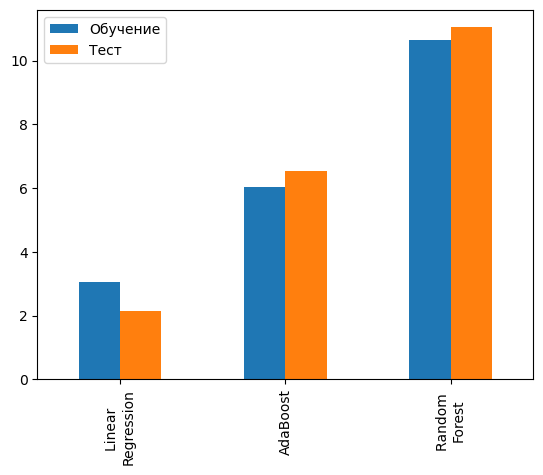

In [65]:
# Визуализация сравнения регрессионных моделей, лучшие результаты по обучающей и тестовой выборке
scores.plot.bar()

#### Нейронная сеть

In [66]:
# Загрузка дополнительных библиотек
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from keras.utils.layer_utils import count_params

In [67]:
# Модель полносвязной нейронной сети
model = Sequential()

model.add(Dense(128, input_dim = X_train.shape[1], activation='relu'))
model.add(Dense(256, activation='softmax'))
model.add(Dense(256, activation='softmax'))
model.add(Dense(256, activation='softmax'))
model.add(Dense(10, activation='linear'))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 10)                2570      
                                                                 
Total params: 168,074
Trainable params: 168,074
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Применение модели
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_split = 0.2)

Epoch 1/15
192/192 [==============================] - 2s 7ms/step - loss: 3.7538 - mean_absolute_error: 3.7538 - val_loss: 3.5513 - val_mean_absolute_error: 3.5513
Epoch 2/15
192/192 [==============================] - 1s 4ms/step - loss: 3.3508 - mean_absolute_error: 3.3508 - val_loss: 3.1324 - val_mean_absolute_error: 3.1324
Epoch 3/15
192/192 [==============================] - 1s 6ms/step - loss: 2.9108 - mean_absolute_error: 2.9108 - val_loss: 2.6728 - val_mean_absolute_error: 2.6728
Epoch 4/15
192/192 [==============================] - 1s 4ms/step - loss: 2.4393 - mean_absolute_error: 2.4393 - val_loss: 2.1927 - val_mean_absolute_error: 2.1927
Epoch 5/15
192/192 [==============================] - 1s 4ms/step - loss: 1.9556 - mean_absolute_error: 1.9556 - val_loss: 1.7068 - val_mean_absolute_error: 1.7068
Epoch 6/15
192/192 [==============================] - 1s 4ms/step - loss: 1.4640 - mean_absolute_error: 1.4640 - val_loss: 1.2026 - val_mean_absolute_error: 1.2026
Epoch 7/15
192/1

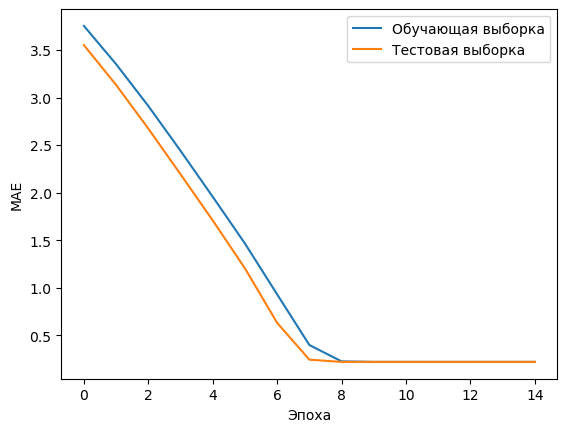

In [69]:
# График работы нейросети
plt.plot(history.history['mean_absolute_error'],
        label = 'Обучающая выборка')
plt.plot(history.history['val_mean_absolute_error'],
         label = 'Тестовая выборка')
plt.xlabel('Эпоха')
plt.ylabel('MAE')
plt.legend()
plt.show()

### 7. Создание рекомендательной системы книг на основе Метода ближайших соседей (KNN).

In [70]:
# Создаем копию основного датасета
df2 = df.copy()

In [71]:
# Разбивка книг на 5 рейтинговых классов
df2.loc[ (df2['average_rating'] >= 0) & (df2['average_rating'] <= 1), 'rating_between'] = 'between 0 and 1'
df2.loc[ (df2['average_rating'] > 1) & (df2['average_rating'] <= 2), 'rating_between'] = 'between 1 and 2'
df2.loc[ (df2['average_rating'] > 2) & (df2['average_rating'] <= 3), 'rating_between'] = 'between 2 and 3'
df2.loc[ (df2['average_rating'] > 3) & (df2['average_rating'] <= 4), 'rating_between'] = 'between 3 and 4'
df2.loc[ (df2['average_rating'] > 4) & (df2['average_rating'] <= 5), 'rating_between'] = 'between 4 and 5'

In [72]:
# Просмотр копии датасета с новой колонкой признака класса
df2.head(10)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,rating_between
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,between 4 and 5
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,between 4 and 5
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,between 4 and 5
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,between 4 and 5
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic,between 4 and 5
5,9,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,0976540606,9780976540601,en-US,152,19,1,4/26/2005,Nimble Books,between 3 and 4
6,10,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,0439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic,between 4 and 5
7,12,The Ultimate Hitchhiker's Guide: Five Complete...,Douglas Adams,4.38,0517226952,9780517226957,eng,815,3628,254,11/1/2005,Gramercy Books,between 4 and 5
8,13,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,0345453743,9780345453747,eng,815,249558,4080,4/30/2002,Del Rey Books,between 4 and 5
9,14,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams,4.22,1400052920,9781400052929,eng,215,4930,460,8/3/2004,Crown,between 4 and 5


In [73]:
df2.shape

(11123, 13)

In [74]:
# Новые классы рейтинга в отдельной таблице
rating_df = pd.get_dummies(df2['rating_between'])
rating_df.head()

,between 0 and 1,between 1 and 2,between 2 and 3,between 3 and 4,between 4 and 5
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1


In [75]:
# Кодируем колонку с языком произведения
language_df = pd.get_dummies(df2['language_code'])
language_df.head()

,ale,ara,en-CA,en-GB,en-US,eng,enm,fre,ger,gla,...,nl,nor,por,rus,spa,srp,swe,tur,wel,zho
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
# Объединяем в одну таблицу признаки для рекомендательной системы
features = pd.concat([rating_df, language_df, df2['average_rating'], df2['ratings_count']], axis=1)
features.head()

,between 0 and 1,between 1 and 2,between 2 and 3,between 3 and 4,between 4 and 5,ale,ara,en-CA,en-GB,en-US,...,por,rus,spa,srp,swe,tur,wel,zho,average_rating,ratings_count
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.57,2095690
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.49,2153167
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.42,6333
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.56,2339585
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.78,41428


In [77]:
# MinMax-масштабирование
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(features)
print(features)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  9.14000000e-01 4.55816060e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  8.98000000e-01 4.68317403e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  8.84000000e-01 1.37743803e-03]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.92000000e-01 1.78351363e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.44000000e-01 1.67258779e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.82000000e-01 2.45776879e-05]]


In [78]:
# Создание модели KNN - ближайших соседей
model = neighbors.NearestNeighbors(n_neighbors=7, algorithm='kd_tree')
model.fit(features)
dist, idlist = model.kneighbors(features)

In [79]:
# Функция работы рекомендателя:
def BookRecommender(book_name):
    book_list_name = []
    book_id = df2[df2['title'] == book_name].index
    book_id = book_id[0]
    for newid in idlist[book_id]:
        book_list_name.append(df2.loc[newid].title)
    return book_list_name

In [80]:
# Проверяем работу рекомендательной системы
BookNames = BookRecommender('The Green Mile')
BookNames

['The Green Mile',
 'Death Note  Vol. 1: Boredom (Death Note  #1)',
 'Voyager (Outlander  #3)',
 'The Complete Stories and Poems',
 'Lover Awakened (Black Dagger Brotherhood  #3)',
 "The Ultimate Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy  #1-5)",
 "Maus I: A Survivor's Tale: My Father Bleeds History (Maus  #1)"]

In [81]:
# Мини-программа для рекомендации
ask = df.title[int(input('Введите порядковый номер книги от 0 до 11123: '))]
print(ask)
rec_books = BookRecommender(input('Копируйте название книги: '))
print('Похожие книги: ', rec_books)

Введите порядковый номер книги от 0 до 11123:  777


La caverna


Копируйте название книги:  La caverna


Похожие книги:  ['La caverna', 'El reino del dragón de oro', 'Artemis Fowl (Artemis Fowl  #1)', 'Noches de tormenta', 'El Escorpion: La Marca del Diablo: El Escorpion: The Mark of the Devil', 'Un café lejos de aquí', 'El código Da Vinci (Robert Langdon  #2)']
